## Self-Organizing Map

In [352]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

%matplotlib inline
%load_ext cython

cuda:0
The cython extension is already loaded. To reload it, use:
  %reload_ext cython


### Implementation

In [347]:
%%cython

import numpy as np
cimport numpy as npc
from cython.parallel import prange

cpdef npc.ndarray euclidian(npc.ndarray a, npc.ndarray b, int axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

cpdef calculate_theta(dst, dem):
     return np.mean(np.exp(-((np.square(dst))/dem)))

cpdef npc.ndarray find_neighbourhood(BMU, npc.ndarray lattice, radius=5):
    ngb = euclidian(BMU, lattice, axis=-1)
    return lattice[np.where((ngb > 0) & (ngb <= radius))]

cpdef npc.ndarray run_som(npc.ndarray X, npc.ndarray W, npc.ndarray lattice, radius, lr, sigma, size):
    dem = (2*(np.square(sigma)))
    for xi in X:
        # Find the BMU of the point
        dist = euclidian(xi, W, axis=-1)
        BMU = np.asarray(np.where(dist==np.min(dist))).ravel()[:size]
        # If found a BMU
        if BMU is not None:
            # Find Neighbourhood of BMU using lattice matrix
            ngb = find_neighbourhood(BMU, lattice, radius)
            # Neighbourhood update
            BMU_node = W[tuple(BMU)]
            for ng in ngb:
                indx = tuple(np.split(ng, size))
                ngb_node = W[indx]
                dst = euclidian(BMU_node, ngb_node, axis=-1)
                theta = calculate_theta(dst, dem)
                W[indx] += theta * (lr * (xi - ngb_node))
            # BMU update
            W[tuple(BMU)] += (lr * (xi - BMU_node))
    return W

In [348]:
class SOM:
    
    def __init__(self, units=2, batch_size=32, lr=1e-1, radius=5):
        self._units = units
        self.W = None
        self._batch_size = batch_size
        self._lr = lr
        self._sig = 1
        self._radius = radius
    
    def train(self, x, epochs=1500, show_iter_err=10):
        qtd, self._size = x.shape
        # Define the Units Weights
        mn, mx, mm = np.min(x), np.max(x), np.mean(x)
        mn += mm
        mx -= mm
        dims = [np.linspace(mn, mx, self._units) for _ in range(self._size)]
        nall = np.meshgrid(*dims)
        idx = np.vstack(tuple(jm.ravel() for jm in nall))
        self.W = np.stack([ix - np.random.uniform(1e-2, 1e-1, 1) for ix in idx], axis=1)
        self.W = self.W.ravel().reshape(self._units, self._units, -1)
        # Create a lattice matrix to find the Neighbourhood of a BMU
        idx = np.indices(self.W.shape[:2])
        idx = np.vstack([ix.flatten() for ix in idx])
        self._lattice = np.stack([ix for ix in idx], axis=1)
        # Running epochs!
        for epoch in range(epochs):
            self.W = run_som(x, self.W, self._lattice, self._radius, self._lr, self._sig, self._size)
            if epoch % 25 == 0 and epoch > 0:
                # Learning rate decay
                self._lr *= np.exp(-epoch/epochs)
                self._sig = self._radius * np.exp(-epoch/epochs)
                if self._radius > 1:
                    self._radius = int(self._radius * np.exp(-epoch/epochs))
    
    def predict(self, x):
        pass

### Toy datasets provided by scikit-learn

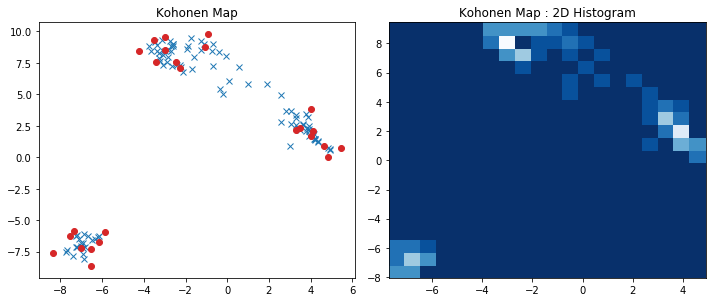

In [349]:
x, y = make_blobs(25, n_features=2, centers=3, random_state=42)

som = SOM(units=10, lr=1e-1, radius=10)
som.train(x, epochs=100)
W = som.W
W = W.flatten().reshape(-1, 2)

fig = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Kohonen Map")
plt.plot(W[:, 0], W[:, 1], 'x', c='C0')
plt.plot(x[:, 0], x[:, 1], 'o', c='C3')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [22]:
X, y = make_moons(500, noise=0.075)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

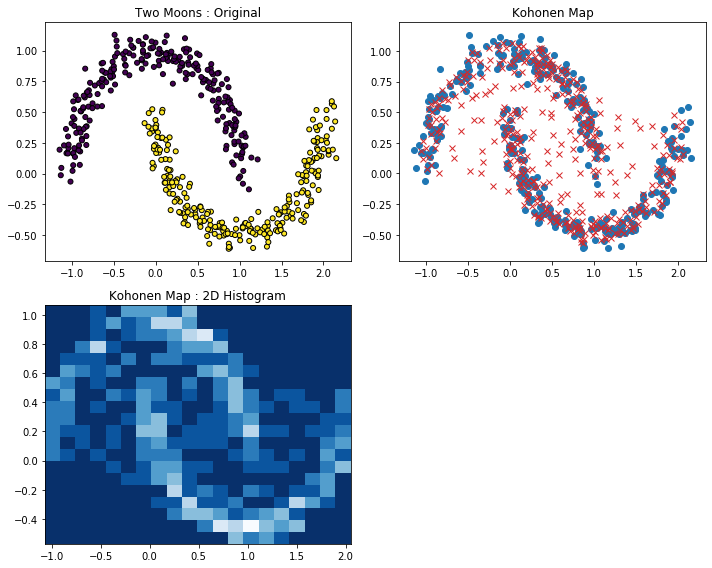

In [23]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [24]:
X, y = make_classification(n_samples=500, n_features=2, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

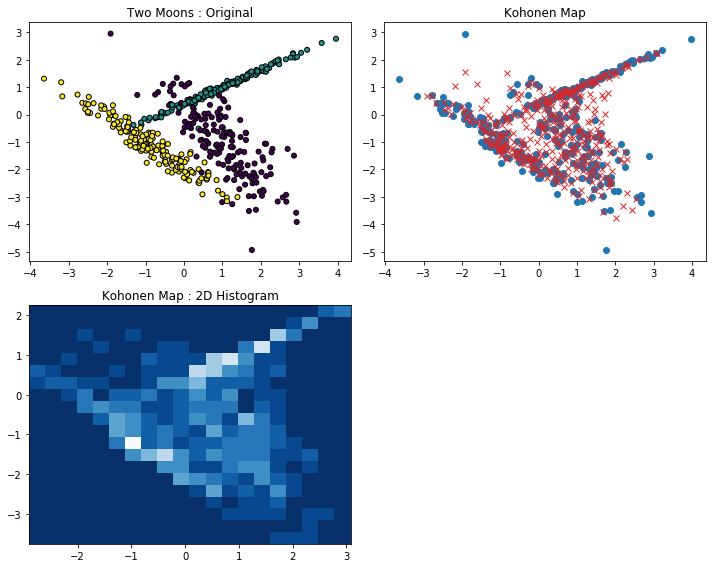

In [25]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [26]:
X, y = make_circles(500, noise=0.03)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

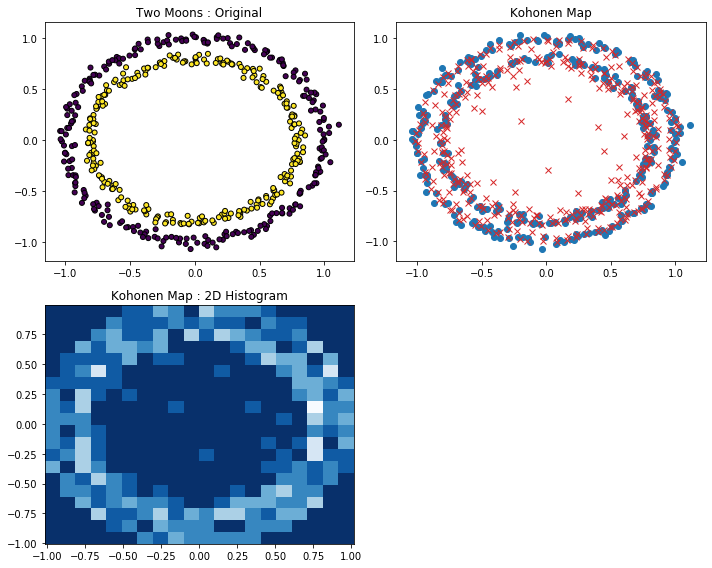

In [27]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [28]:
X, y = make_blobs(500, n_features=2, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

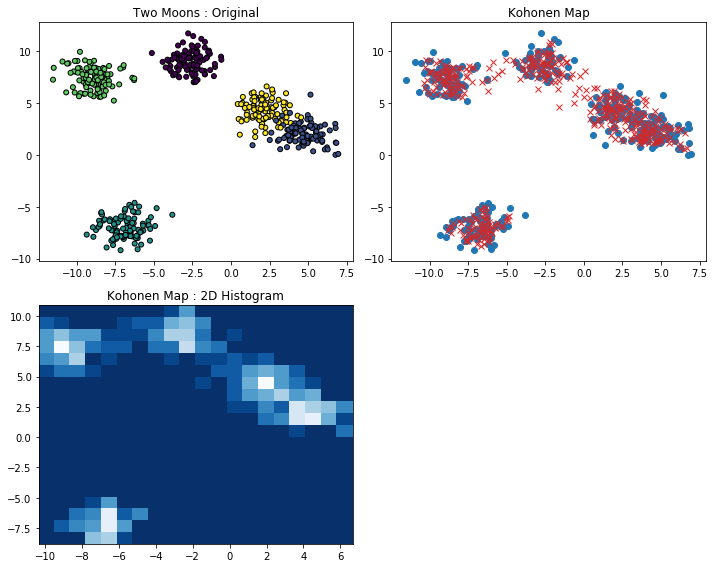

In [29]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

## Self-organizing map on MNIST

#### Applying PCA and T-SNE to MNIST and after that SOM

Loading MNIST from scikit-learn to test out against the self-Organizing Map.

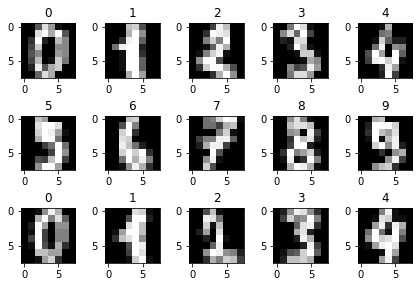

In [356]:
digits = load_digits(n_class=10)
x = digits.data
y = digits.target

for i in range(15):
    img, title = x[i], y[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.reshape(8, 8), cmap="gray")
plt.tight_layout()
plt.show()

In [360]:
x_pca = TruncatedSVD(n_components=2, random_state=42).fit_transform(x)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(x_pca, epochs=100)
W = som.W.flatten().reshape(-1, 2)

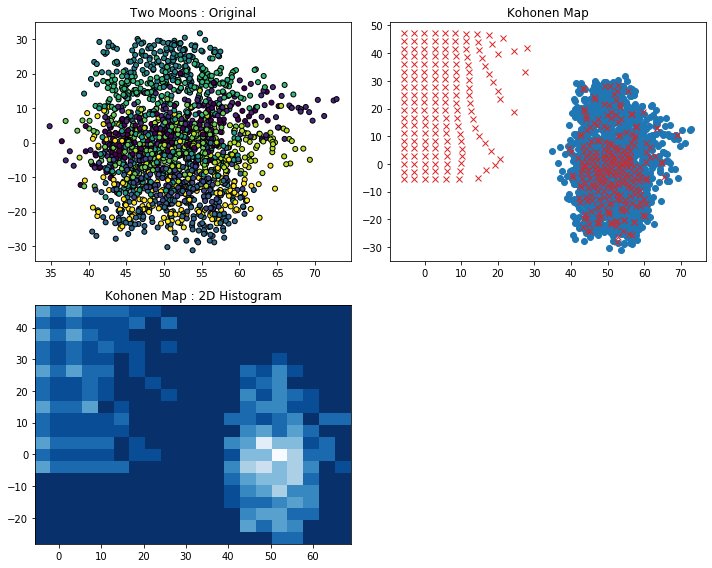

In [361]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [362]:
x_tsne = TSNE(n_components=2, init='pca', random_state=0).fit_transform(x)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(x_tsne, epochs=100)
W = som.W.flatten().reshape(-1, 2)

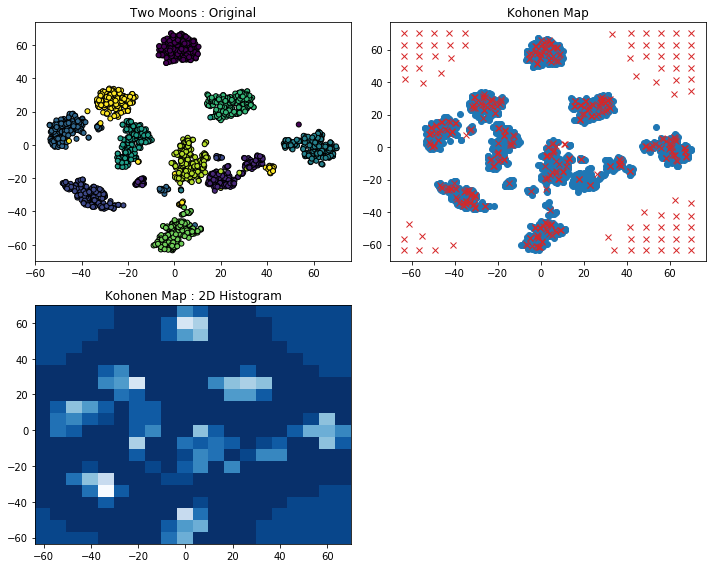

In [365]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

#### Autoencoder

Taken from : [Building Autoencoder in Pytorch](https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c)

The problem with the above techniques is that it works fine with a low dimensional image, like the toy MNIST provided by scikit-learn.

If one try with the MNIST dataset provided by pytorch, well... it a little differente history.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
for i in range(15):
    img, title = mnist_trainset.data[i], mnist_trainset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.numpy(), cmap="gray")
plt.tight_layout()
plt.show()

In [129]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=10):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, device):
        super(VAE, self).__init__()
        self.__device = device
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            Flatten()
        )
        
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(10, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(self.__device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 2),
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [130]:
num_epochs = 25

model = VAE(device).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in trainloader:
        inputs, labels = data
        # ===================forward=====================
        outputs, mu, logvar = model(inputs.to(device))
        print(inputs.size())
        print(outputs.size())
        loss = criterion(outputs.to(device), inputs.to(device))
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss))

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 16, 16])


RuntimeError: The size of tensor a (16) must match the size of tensor b (28) at non-singleton dimension 3

In [79]:
outputs = None
labels = []
for i, data in enumerate(testloader, 0):
    inputs, lbs = data
    outputs = model(inputs.to(device))
    labels.append(lbs)
    break
outputs = outputs.cpu()
# print(outputs[0].data)
pic = to_img(outputs[0].data)
save_image(pic, './image_{}.png'.format(1))